# Import libraries and modules

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from stock_LSTM import StockLSTM
from dataset_creation import StockDataset
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

# Load Dataset

In [2]:
base_path = "price/raw"
df = pd.read_csv(f"{base_path}/AAPL.csv")
print(len(df))

1258


In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-09-04,95.108574,96.448570,94.928574,96.424286,87.121140,91973000
1,2012-09-05,96.510002,96.621429,95.657143,95.747147,86.509338,84093800
2,2012-09-06,96.167145,96.898575,95.828575,96.610001,87.288956,97799100
3,2012-09-07,96.864288,97.497147,96.538574,97.205711,87.827171,82416600
4,2012-09-10,97.207146,97.612854,94.585716,94.677139,85.542564,121999500


In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[['Open','High','Low','Close','Volume']] = scaler.fit_transform(df[['Open','High','Low','Close','Volume']])

In [16]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-09-04,0.362825,0.364963,0.367482,0.375340,87.121140,0.227562
1,2012-09-05,0.375638,0.366566,0.374189,0.369085,86.509338,0.205288
2,2012-09-06,0.372504,0.369136,0.375768,0.377055,87.288956,0.244032
3,2012-09-07,0.378878,0.374685,0.382305,0.382558,87.827171,0.200546
4,2012-09-10,0.382012,0.375758,0.364325,0.359201,85.542564,0.312446


# Prepare dataset

In [24]:
feature_columns = ['Open','High','Low','Close','Volume']
# feature_columns = ['Close']
filtered_df = df[feature_columns]
seq_len = 4
train_size = int(len(filtered_df) * 0.8)
train_data = filtered_df.iloc[:train_size]
test_data = filtered_df.iloc[train_size:]


In [25]:
try:
    train_dataset = StockDataset(train_data, seq_len, feature_columns)
    test_dataset = StockDataset(test_data, seq_len, feature_columns)
    print("Datasets created successfully!")
except Exception as e:
    print(f"Error creating dataset: {e}")

Datasets created successfully!


In [26]:
train_dataset[0]

(tensor([[0.3628, 0.3650, 0.3675, 0.3753, 0.2276],
         [0.3756, 0.3666, 0.3742, 0.3691, 0.2053],
         [0.3725, 0.3691, 0.3758, 0.3771, 0.2440],
         [0.3789, 0.3747, 0.3823, 0.3826, 0.2005]]),
 tensor(0.3592))

In [27]:
# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



# Model initialization

In [39]:
input_size = len(feature_columns)

model = StockLSTM(input_size=input_size, hidden_size=64, num_layers=2)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [40]:
epochs = 20
for epoch in range(epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

# Test the model
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        predictions.extend(outputs.squeeze().numpy())
        actuals.extend(targets.numpy())

Epoch 1/20, Loss: 0.016962366178631783
Epoch 2/20, Loss: 0.0017947066808119416
Epoch 3/20, Loss: 0.001562976511195302
Epoch 4/20, Loss: 0.0004431648994795978
Epoch 5/20, Loss: 0.0002644591440912336
Epoch 6/20, Loss: 0.0002786054101306945
Epoch 7/20, Loss: 0.00042878539534285665
Epoch 8/20, Loss: 0.0002976561663672328
Epoch 9/20, Loss: 0.0005046011065132916
Epoch 10/20, Loss: 0.0005667489022016525
Epoch 11/20, Loss: 0.0005658010486513376
Epoch 12/20, Loss: 0.00010729060886660591
Epoch 13/20, Loss: 0.00048751517897471786
Epoch 14/20, Loss: 0.00039962181472219527
Epoch 15/20, Loss: 0.0010254608932882547
Epoch 16/20, Loss: 0.0005392379243858159
Epoch 17/20, Loss: 0.0005411413148976862
Epoch 18/20, Loss: 0.000496750813908875
Epoch 19/20, Loss: 0.000362515973392874
Epoch 20/20, Loss: 0.0003012516535818577


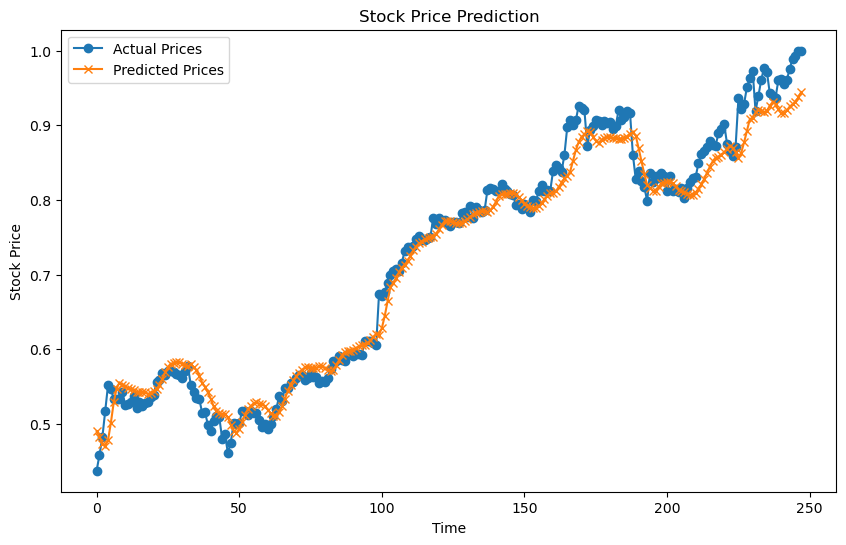

In [41]:
# Visualize results
plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actual Prices', marker='o')
plt.plot(predictions, label='Predicted Prices', marker='x')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()